# **Crop Yield Prediction**

# **1. Data Overview**

## **1.1. Importing Libararies**

In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## **1.2. Reading Data and Header View**

In [223]:
df = pd.read_csv('Crop_Yield_Prediction.csv')
df.head()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Crop,Yield
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Rice,7000
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Rice,5000
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Rice,7000
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Rice,7000
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Rice,120000


##  **1.3. Shape of Data**

In [224]:
df.shape

(2200, 9)

## **1.4. Null Values Distribution**

In [225]:
df.isnull().sum()

Nitrogen       0
Phosphorus     0
Potassium      0
Temperature    0
Humidity       0
pH_Value       0
Rainfall       0
Crop           0
Yield          0
dtype: int64

## **1.5. Basic Info about Data**

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2200 non-null   int64  
 1   Phosphorus   2200 non-null   int64  
 2   Potassium    2200 non-null   int64  
 3   Temperature  2200 non-null   float64
 4   Humidity     2200 non-null   float64
 5   pH_Value     2200 non-null   float64
 6   Rainfall     2200 non-null   float64
 7   Crop         2200 non-null   object 
 8   Yield        2200 non-null   int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 154.8+ KB


## **1.6. Data Types of Each Column**

In [227]:
df.dtypes

Nitrogen         int64
Phosphorus       int64
Potassium        int64
Temperature    float64
Humidity       float64
pH_Value       float64
Rainfall       float64
Crop            object
Yield            int64
dtype: object

## **1.7. Describe Data**

In [228]:
df.describe(include='all').round(2).style.format(precision=2).background_gradient(cmap="Reds")

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Crop,Yield
count,2200.00,2200.00,2200.00,2200.00,2200.00,2200.00,2200.00,2200,2200.00
unique,nan,nan,nan,nan,nan,nan,nan,22,nan
top,nan,nan,nan,nan,nan,nan,nan,Rice,nan
freq,nan,nan,nan,nan,nan,nan,nan,100,nan
mean,50.55,53.36,48.15,25.62,71.48,6.47,103.46,nan,2689.23
std,36.92,32.99,50.65,5.06,22.26,0.77,54.96,nan,3710.36
min,0.00,5.00,5.00,8.83,14.26,3.50,20.21,nan,2.00
25%,21.00,28.00,20.00,22.77,60.26,5.97,64.55,nan,950.00
50%,37.00,51.00,32.00,25.60,80.47,6.43,94.87,nan,1825.00
75%,84.25,68.00,49.00,28.56,89.95,6.92,124.27,nan,3500.00


## **1.8. Value Counts of Crop**

In [229]:
df['Crop'].value_counts()

Crop
Rice           100
Maize          100
Jute           100
Cotton         100
Coconut        100
Papaya         100
Orange         100
Apple          100
Muskmelon      100
Watermelon     100
Grapes         100
Mango          100
Banana         100
Pomegranate    100
Lentil         100
Blackgram      100
MungBean       100
MothBeans      100
PigeonPeas     100
KidneyBeans    100
ChickPea       100
Coffee         100
Name: count, dtype: int64

# **2. Exploratory Data Analysis**

## **2.1. Plot histograms for numerical features**

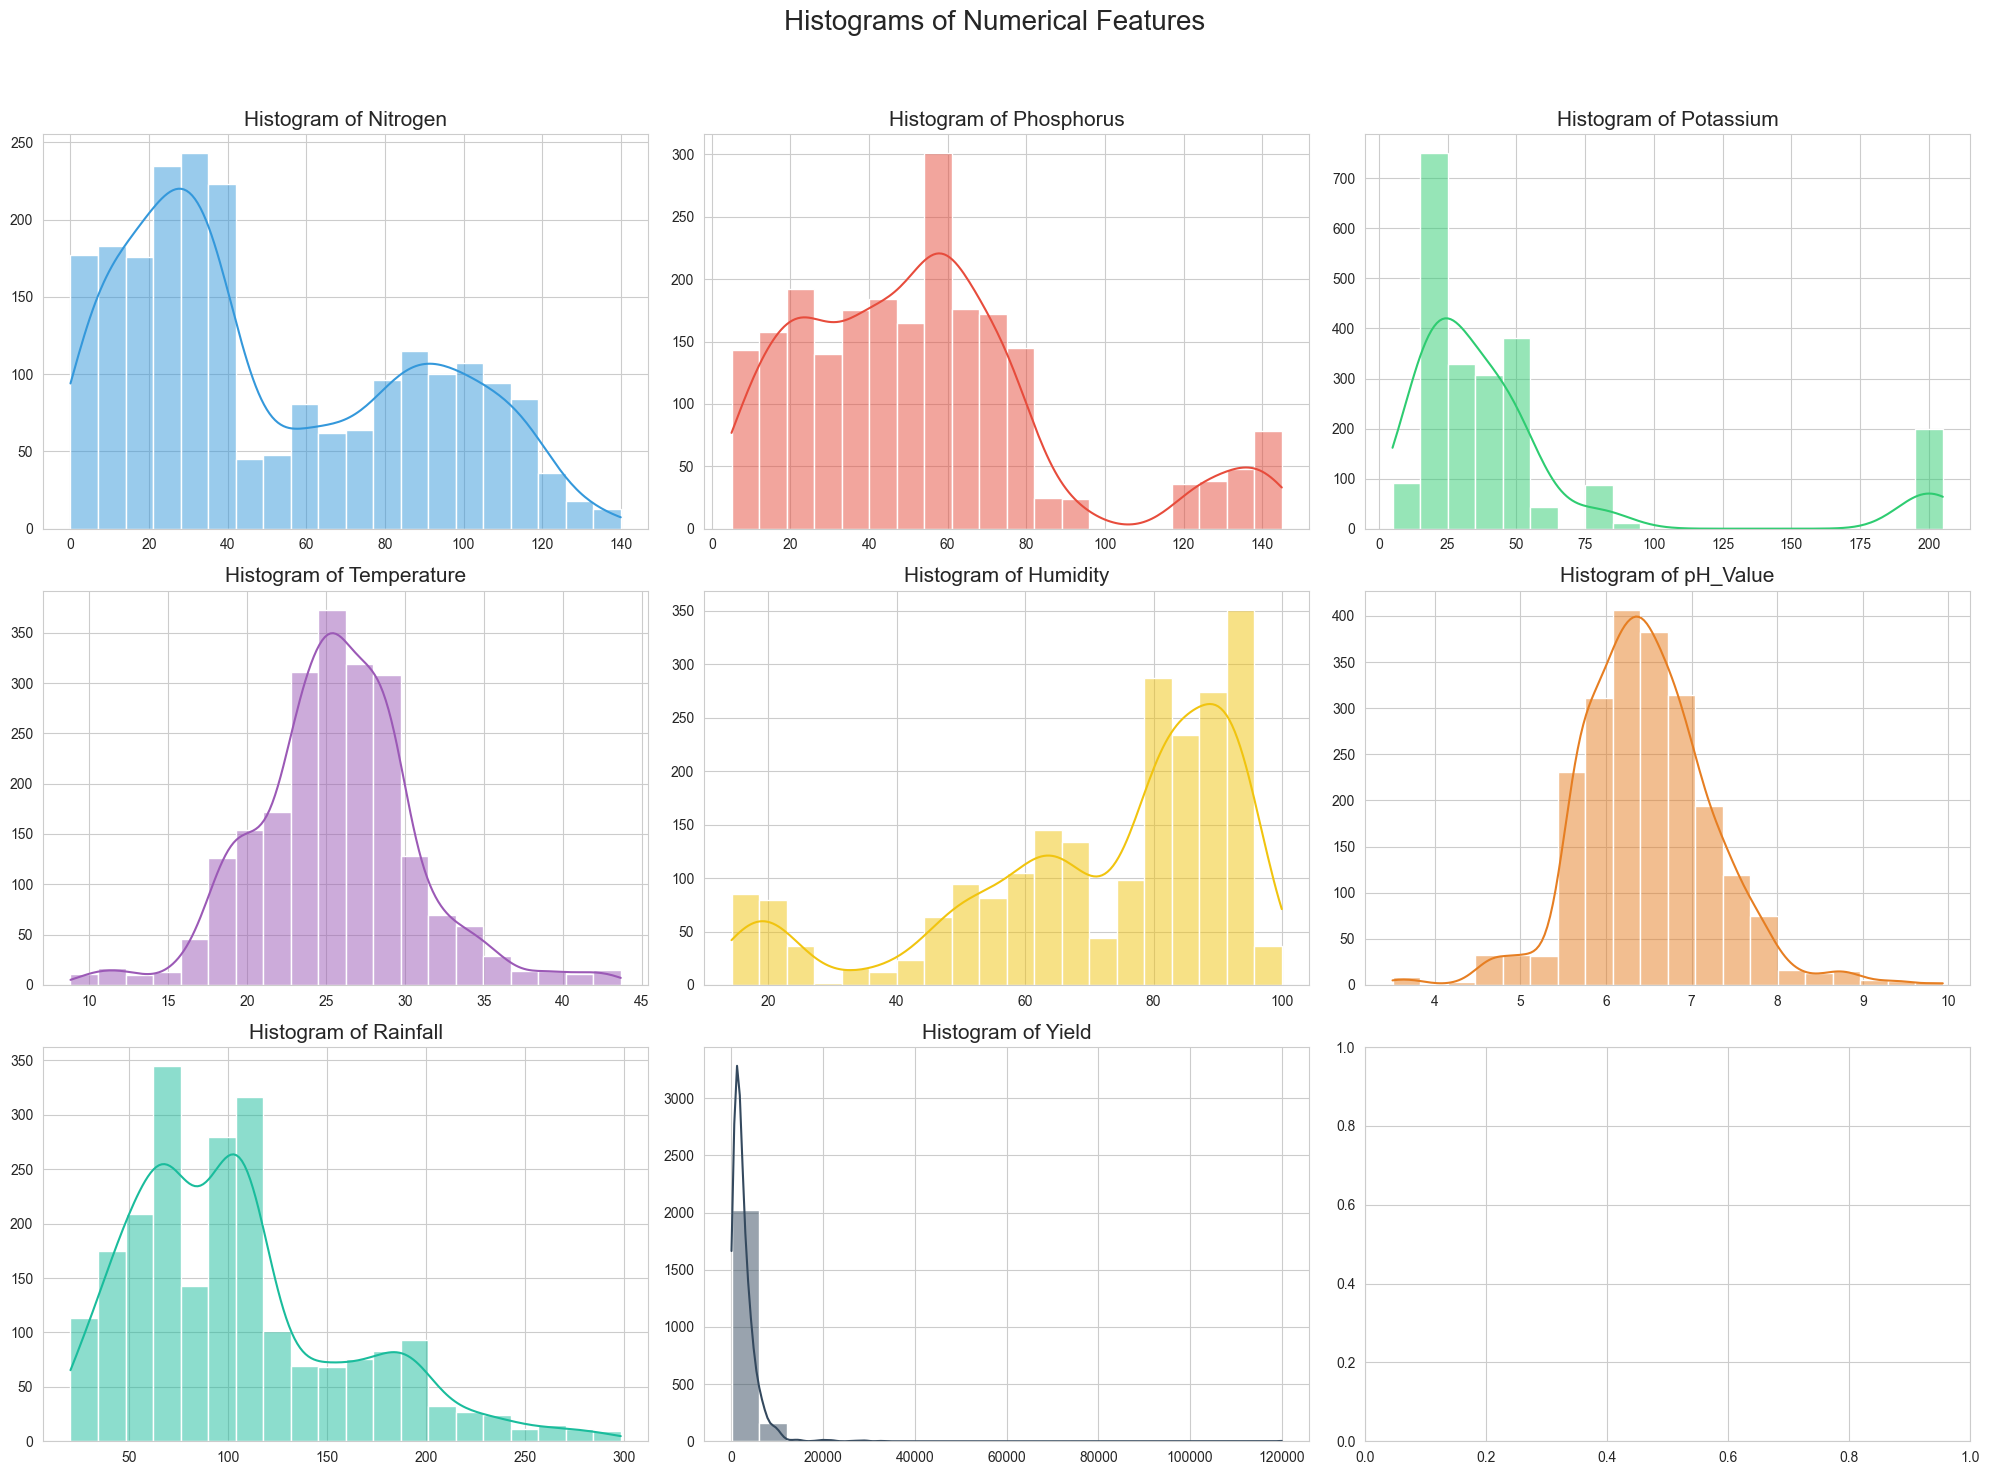

In [230]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
fig.suptitle('Histograms of Numerical Features', size=20)
axes = axes.flatten()

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f1c40f', '#e67e22', '#1abc9c', '#34495e', '#d35400']

for i, (ax, column) in enumerate(zip(axes, df.select_dtypes(include=['int64', 'float64']).columns)):
    sns.histplot(df[column], bins=20, color=colors[i], kde=True, ax=ax)
    ax.set_title(f'Histogram of {column}', size=15)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## **2.2. Box plots for numerical features**

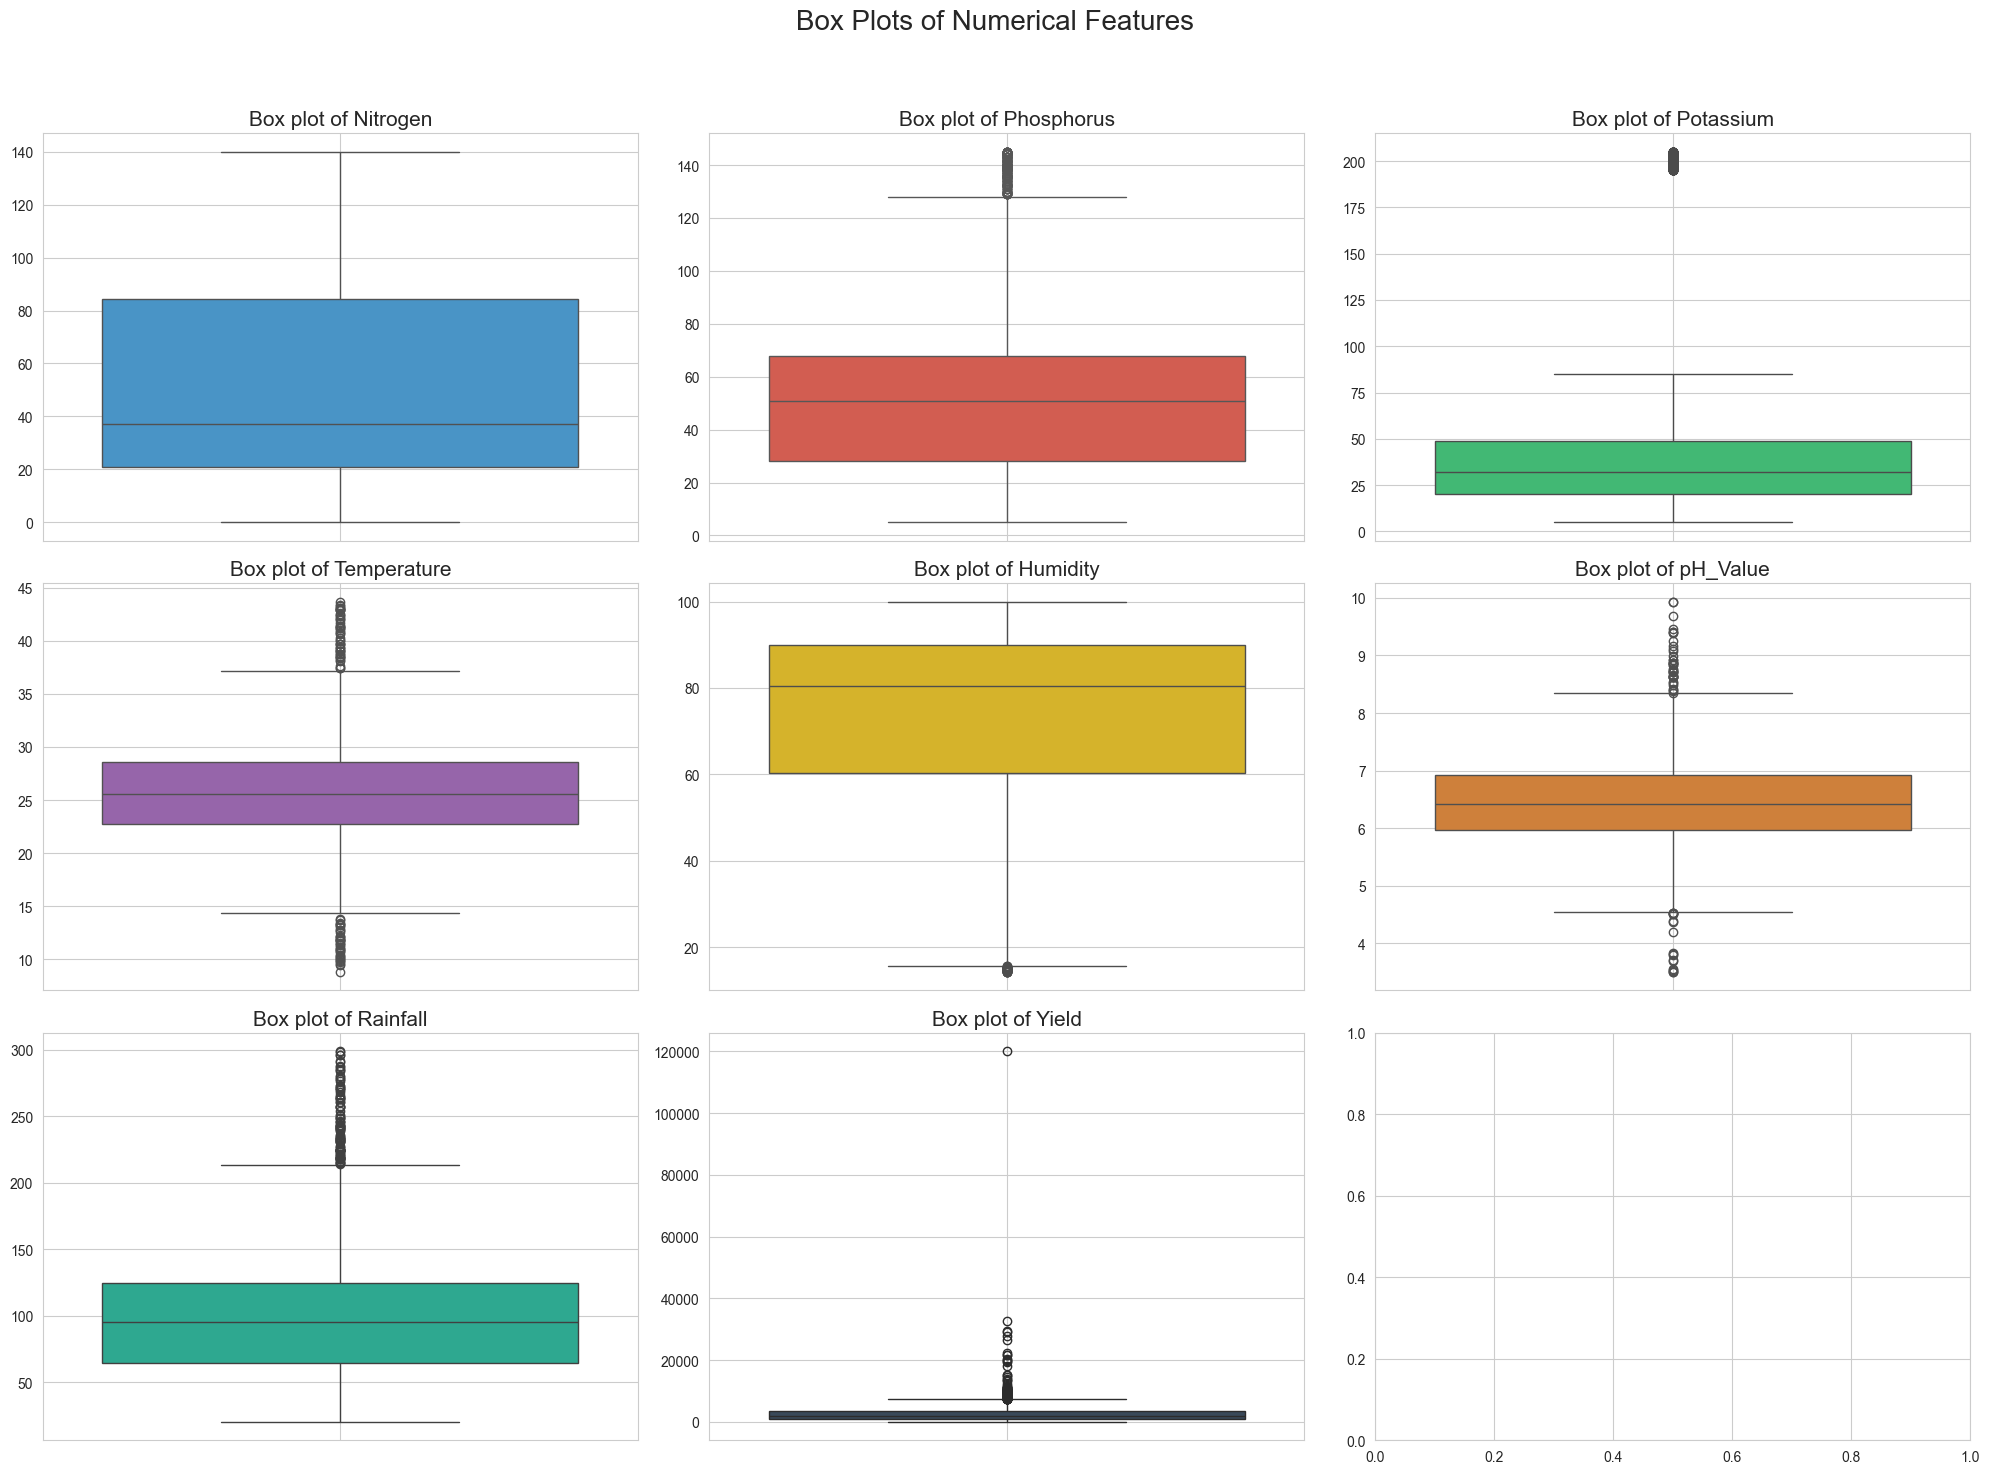

In [231]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
fig.suptitle('Box Plots of Numerical Features', size=20)
axes = axes.flatten()

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f1c40f', '#e67e22', '#1abc9c', '#34495e', '#d35400']

for i, (ax, column) in enumerate(zip(axes, df.select_dtypes(include=['int64', 'float64']).columns)):
    sns.boxplot(df[column], ax=ax, color=colors[i])
    ax.set_title(f'Box plot of {column}', size=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## **2.3. Pair plot for the entire dataset**

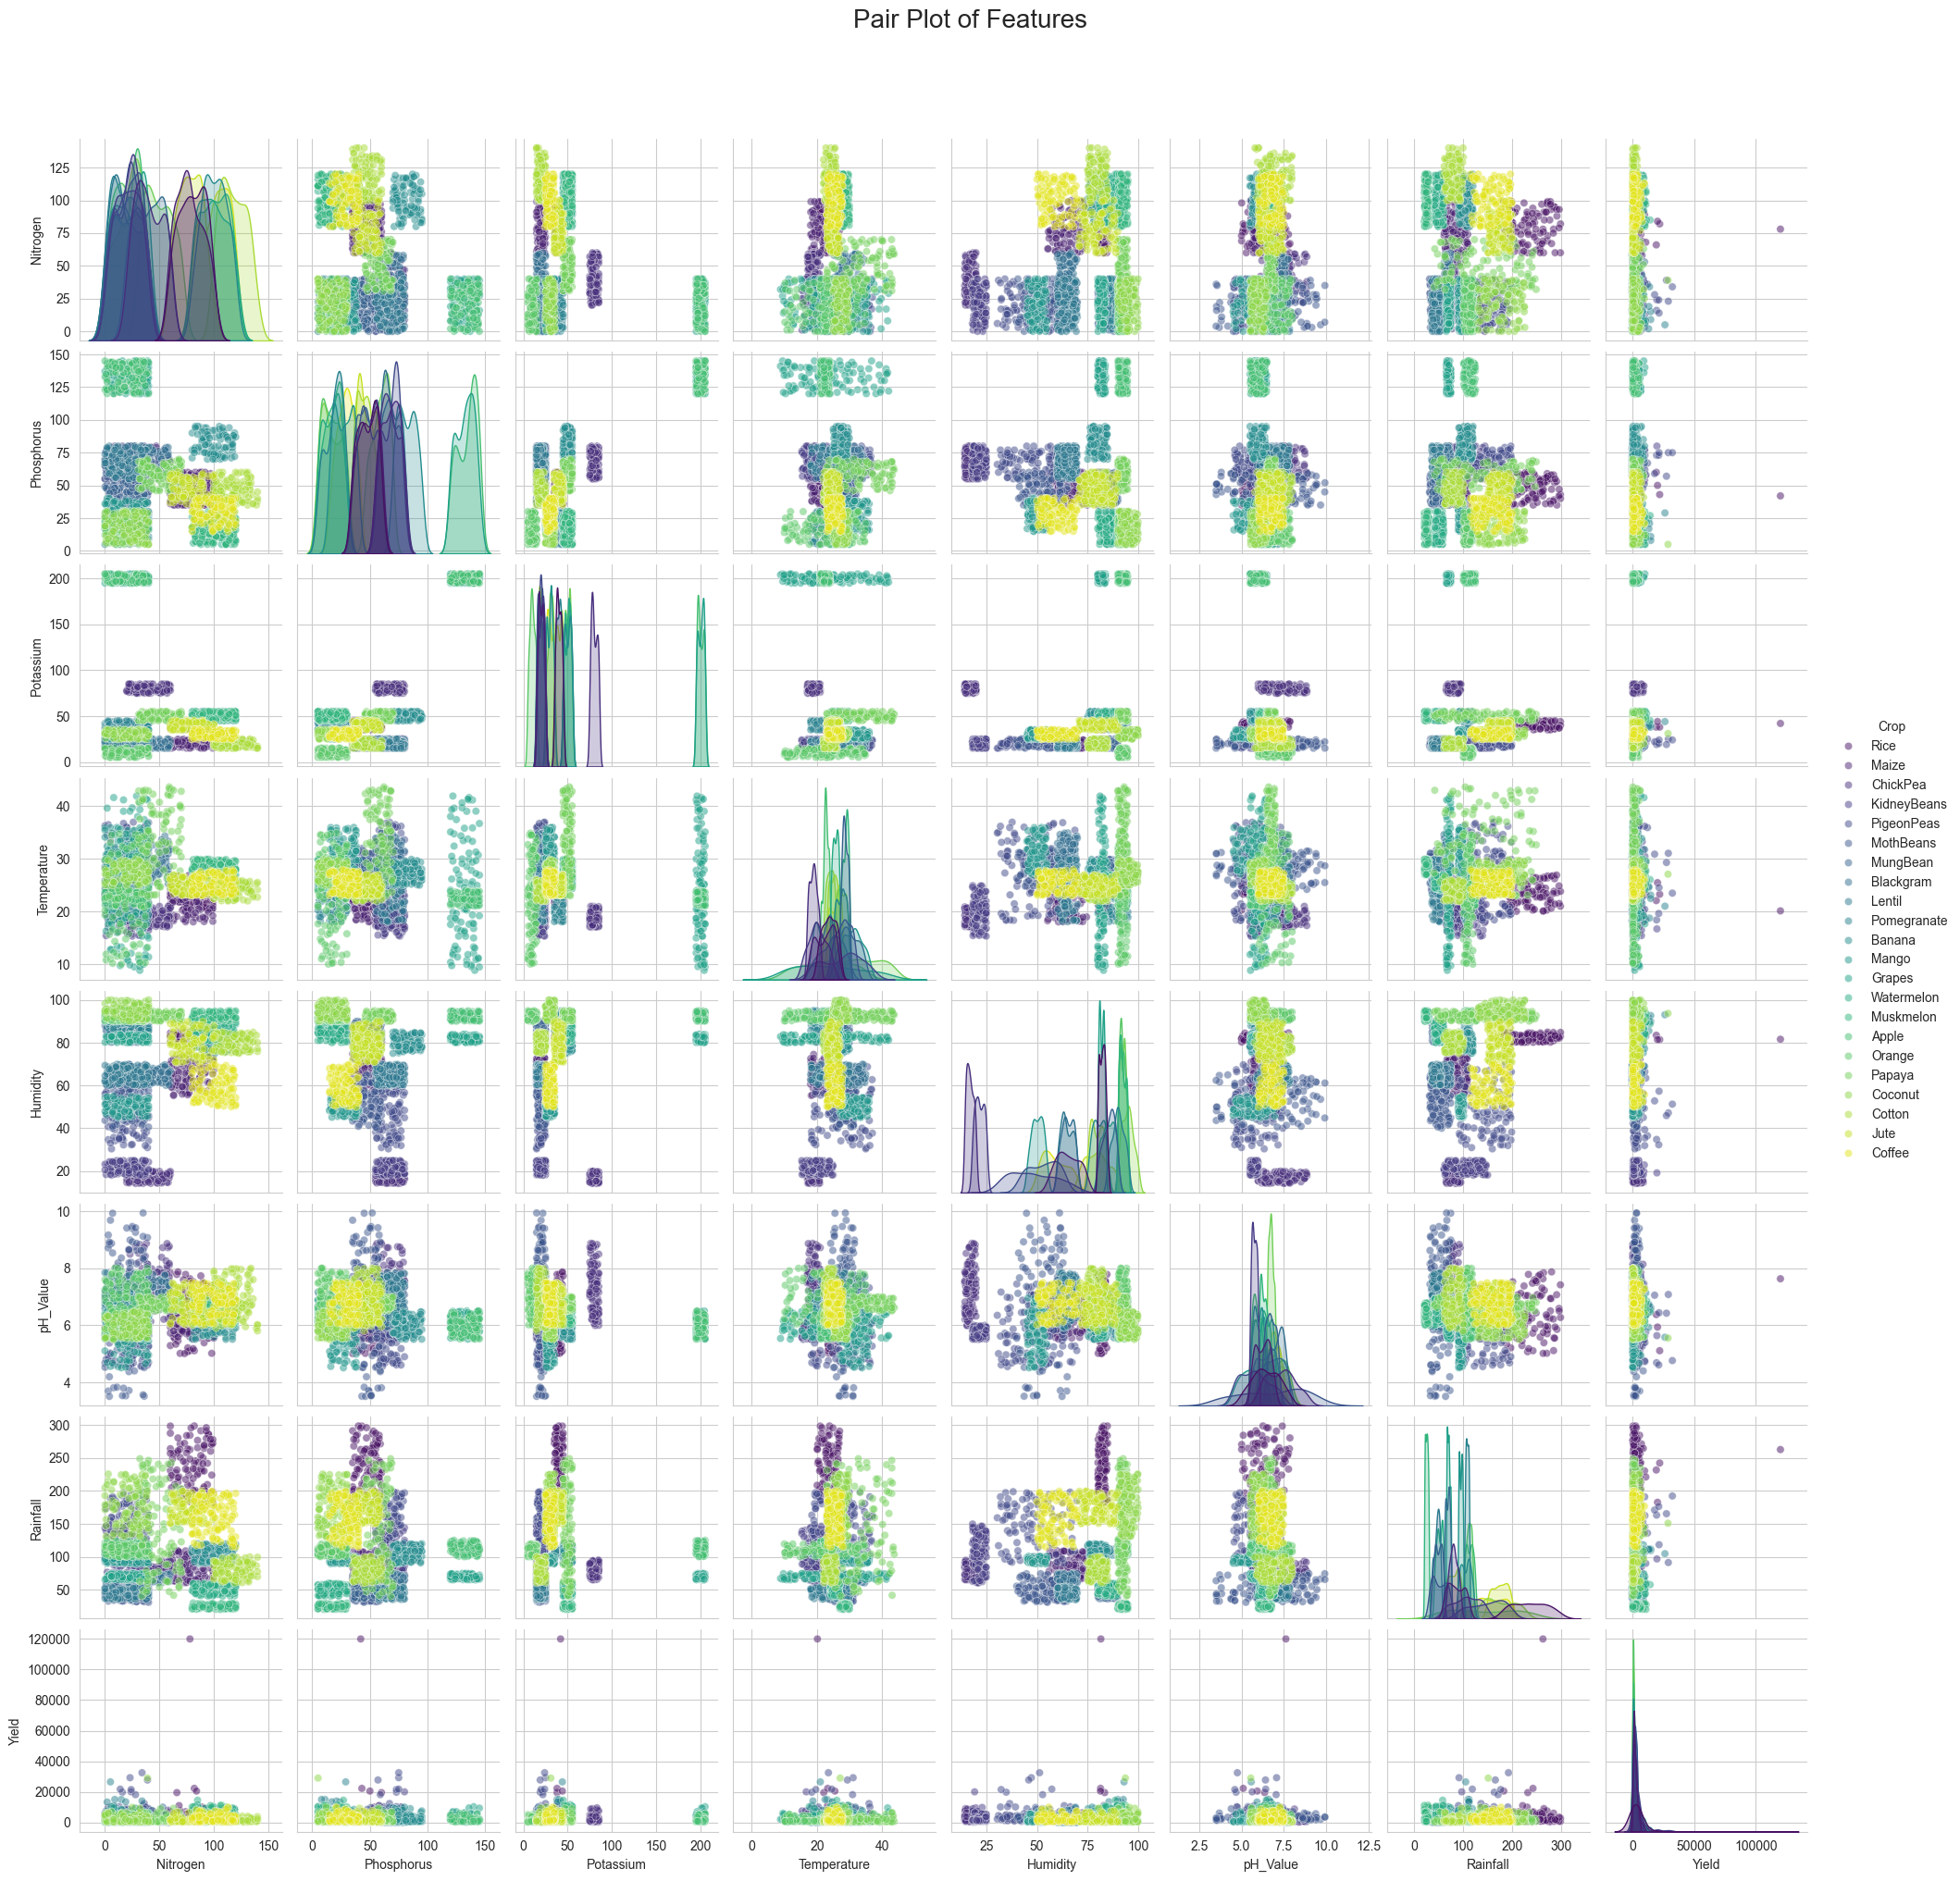

In [232]:
sns.set_style("whitegrid")

pair_plot = sns.pairplot(df, hue='Crop', palette='viridis', plot_kws={'alpha':0.5})
plt.suptitle('Pair Plot of Features', size=20, y=1.02)
plt.subplots_adjust(top=0.95)

plt.show()

## **2.4. Count plot for crop distribution**

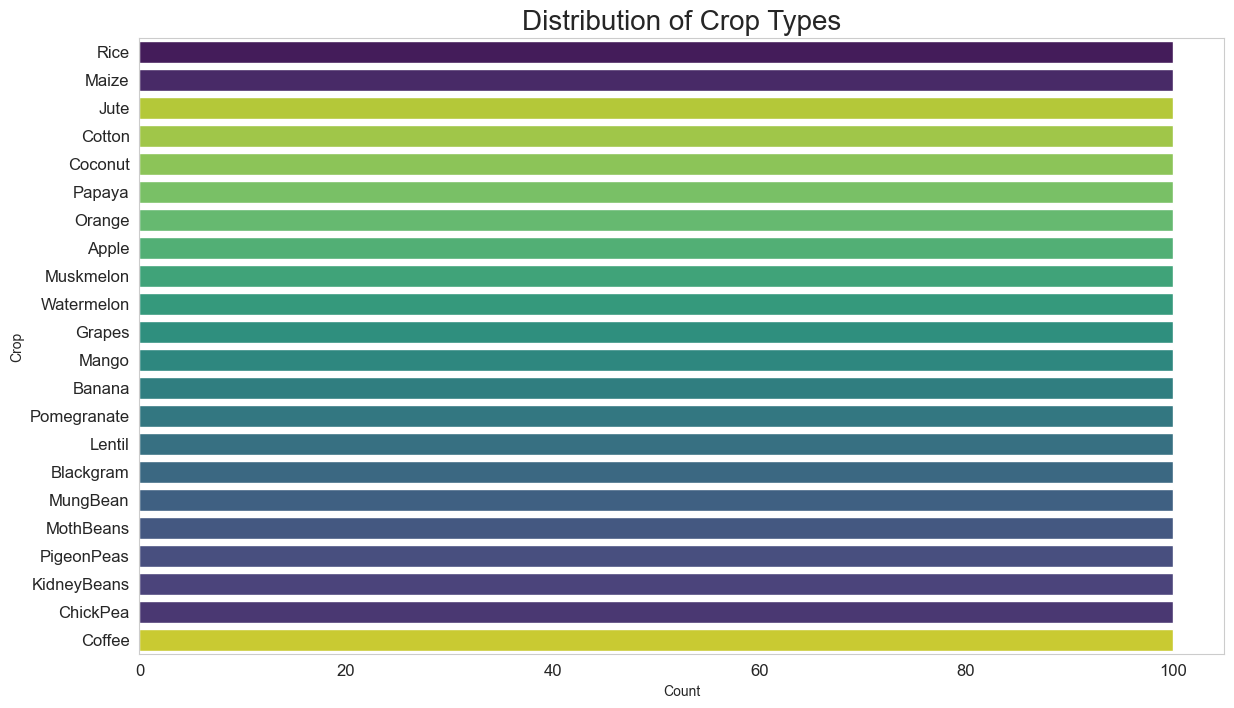

In [233]:
sns.set_style("whitegrid")

plt.figure(figsize=(14, 8))
sns.countplot(data=df, y='Crop', 
            palette='viridis', 
            order=df['Crop'].value_counts().index, 
            hue='Crop', dodge=False, legend=False)
plt.title('Distribution of Crop Types', size=20)
plt.xlabel('Count')
plt.ylabel('Crop')
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(axis='x')

plt.show()

# **3. Handling Outliers**

## **3.1. Defining IQR Method and Capping**

In [234]:
def handle_outliers_iqr(df):
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    return df

df = handle_outliers_iqr(df)

## **3.2. Checking Outliers after Capping**

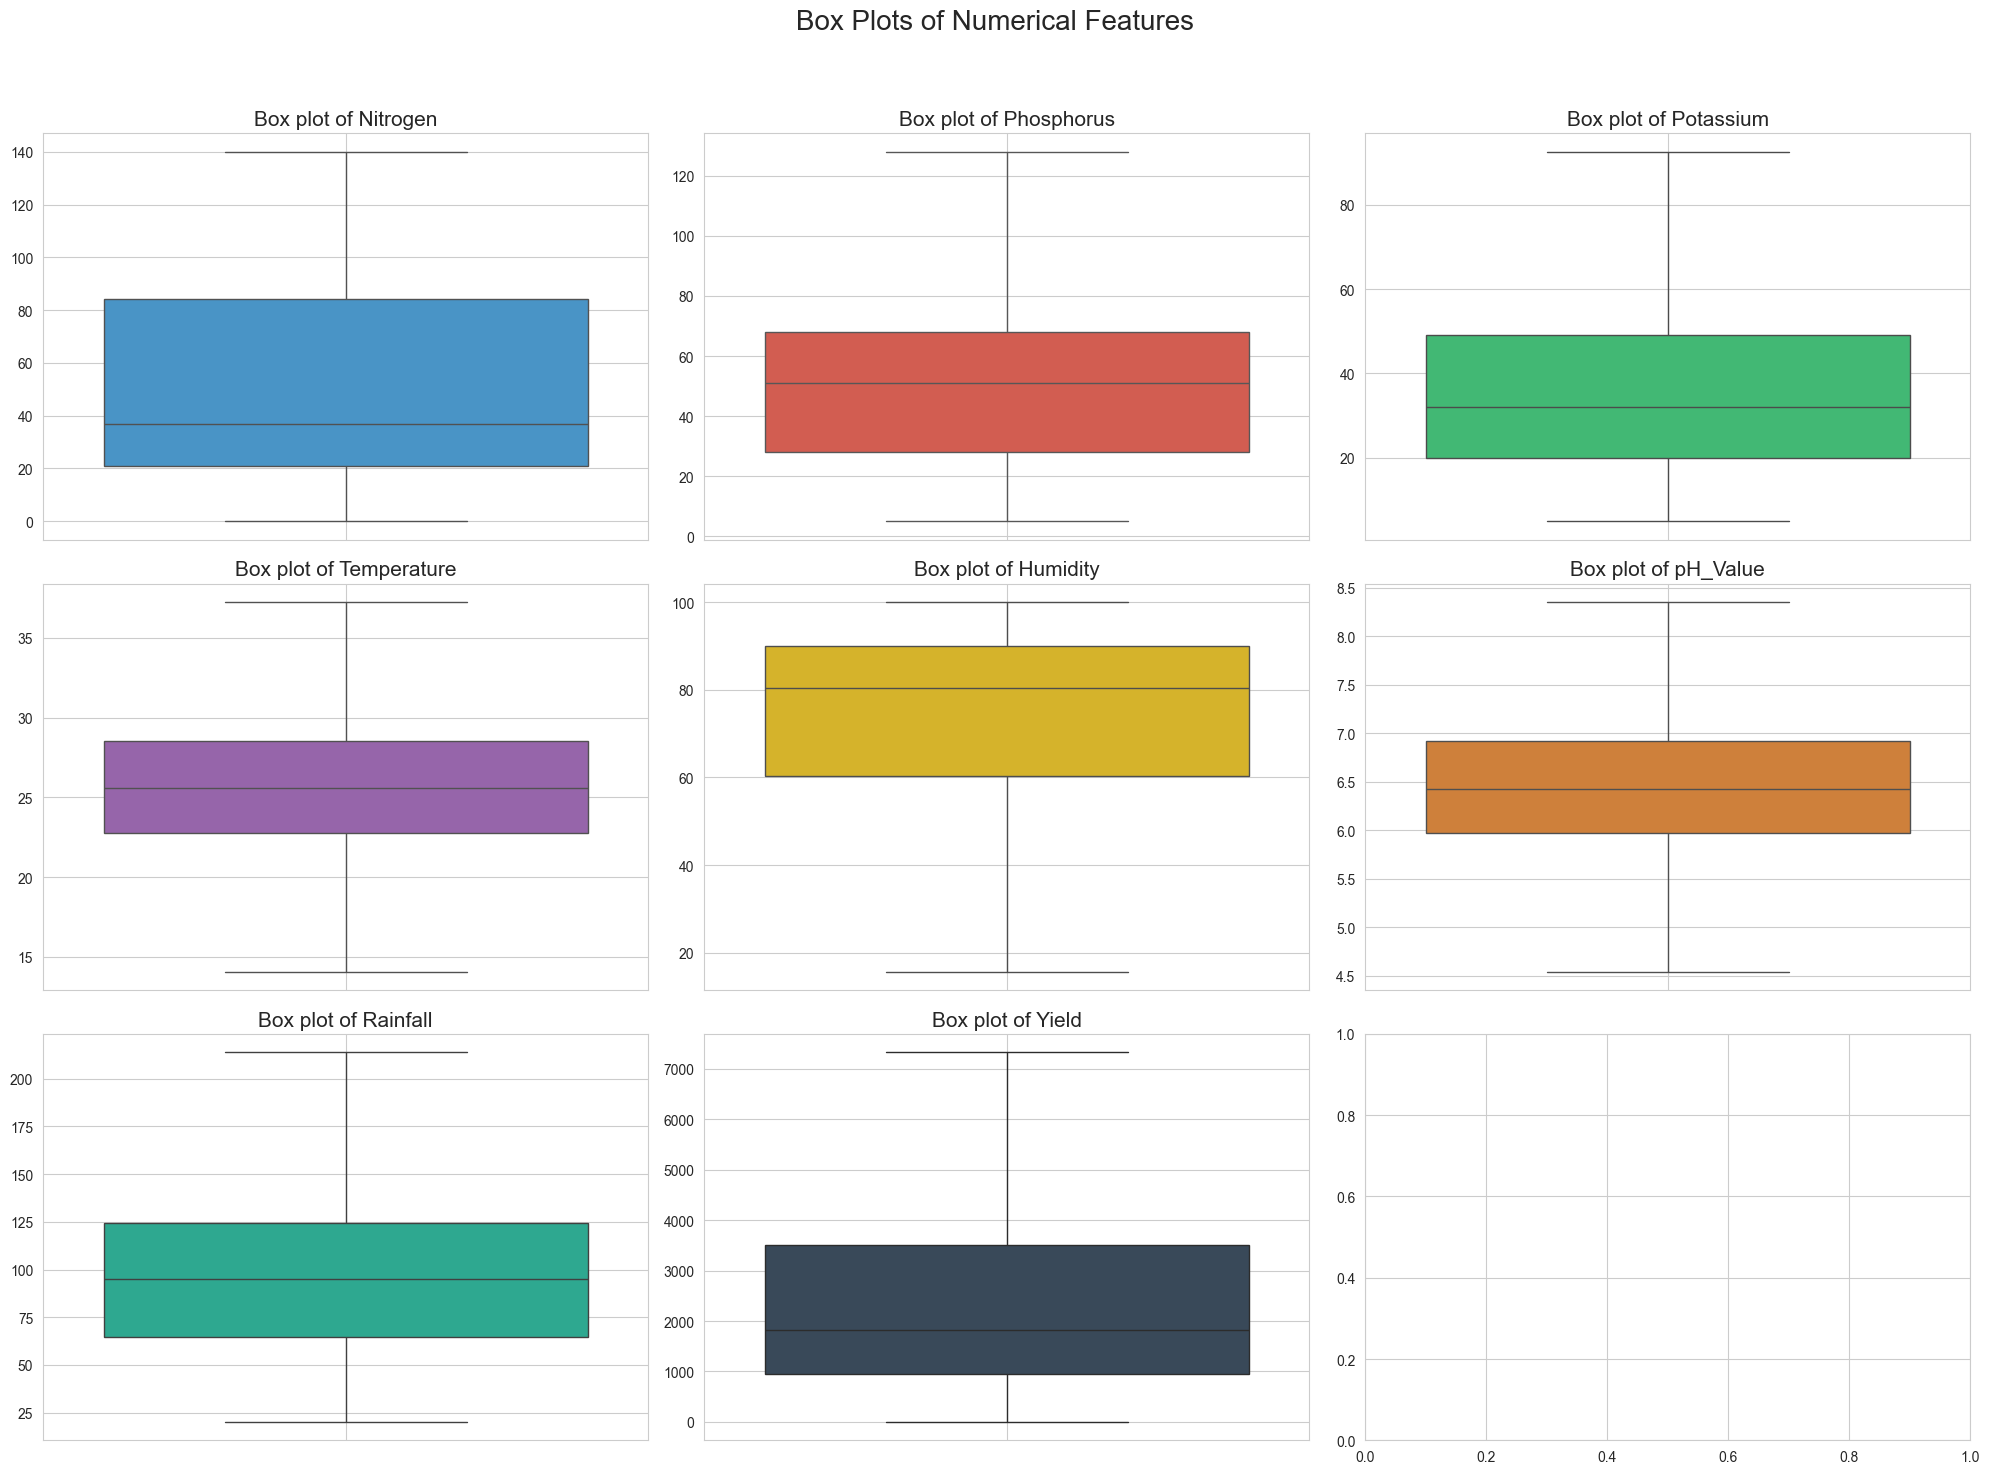

In [235]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
fig.suptitle('Box Plots of Numerical Features', size=20)
axes = axes.flatten()

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f1c40f', '#e67e22', '#1abc9c', '#34495e', '#d35400']

for i, (ax, column) in enumerate(zip(axes, df.select_dtypes(include=['int64', 'float64']).columns)):
    sns.boxplot(df[column], ax=ax, color=colors[i])
    ax.set_title(f'Box plot of {column}', size=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# **4. Feature Engineering**

## **4.1. Train Test Split**

In [236]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Yield']),
                                                    df['Yield'],
                                                    test_size=0.2,
                                                    random_state=42)

## **4.2. Separating Numerical and Categorical Columns Indices**

In [237]:
numerical_columns = [0, 1, 2, 3, 4, 5, 6]
categorical_columns = [7]

## **4.3. Creating Pipelines**

In [238]:
handle_numerical = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

In [239]:
handle_categorical = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

## **4.4. Combining Pipelines**

In [240]:
preprocessing = ColumnTransformer(transformers=[
    ('numerical', handle_numerical, numerical_columns),
    ('categorical', handle_categorical, categorical_columns)
], remainder='passthrough')

# **5. Modeling and Evaluation**

## **5.1. Random Forest Regressor**

In [241]:
rf = RandomForestRegressor()

In [242]:
pipe_rf = make_pipeline(preprocessing, rf)

In [243]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7])])),
                ('randomforestregressor', RandomForestRegressor())])

In [244]:
y_pred_rf = pipe_rf.predict(X_test)

In [245]:
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)

print('Mean Absolute Error ', mae)
print('Mean Squared Error ', mse)

Mean Absolute Error  1549.2274090909093
Mean Squared Error  3852581.8364522727


## **5.2. Ada Boost Regressor**

In [246]:
ada = AdaBoostRegressor()

In [247]:
pipe_ada = make_pipeline(preprocessing, ada)

In [248]:
pipe_ada.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7])])),
                ('adaboostregressor', AdaBoostRegressor())])

In [249]:
y_pred_ada = pipe_ada.predict(X_test)

In [250]:
mae = mean_absolute_error(y_test, y_pred_ada)
mse = mean_squared_error(y_test, y_pred_ada)

print('Mean Absolute Error ', mae)
print('Mean Squared Error ', mse)

Mean Absolute Error  1654.7502049784553
Mean Squared Error  3796709.2257443788


## **5.3. XGB Regressor**

In [251]:
xgb = XGBRegressor()

In [252]:
pipe_xgb = make_pipeline(preprocessing, xgb)

In [253]:
pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7])])),
                ('xgbregressor'...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [254]:
y_pred_xgb = pipe_xgb.predict(X_test)

In [255]:
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
r2score = r2_score(y_test, y_pred_xgb)

print('Mean Absolute Error ', mae)
print('Mean Squared Error ', mse)

Mean Absolute Error  1585.4196732694452
Mean Squared Error  4240632.738262087


# **6. Pickling Model**

In [256]:
import joblib
joblib.dump(pipe_rf, 'best_model.pkl')

['best_model.pkl']